### 라이브러리 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### 데이터 확인

In [2]:
dataset = pd.read_csv('train.csv')
dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### X_data 와 y_data 구분

In [4]:
X_data = dataset.drop(['label'], 1)
X_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y_data = dataset[['label']]
y_data.head()

,label
0,1
1,0
2,1
3,4
4,0


### train data 와 valid data 구분

In [6]:
train_X, valid_X, train_Y, valid_Y = train_test_split(X_data, y_data, test_size=0.25, random_state=42)

### Custom Dataset과 DataLoader 사용하여 데이터 불러오기

In [7]:
t_train = torch.utils.data.TensorDataset(torch.Tensor(train_X.values).type(torch.float32), torch.Tensor(train_Y['label'].values).type(torch.LongTensor))
t_valid = torch.utils.data.TensorDataset(torch.Tensor(valid_X.values).type(torch.float32), torch.Tensor(valid_Y['label'].values).type(torch.LongTensor))

In [8]:
train_dl = torch.utils.data.DataLoader(dataset=t_train, batch_size=16, shuffle=True)
valid_dl = torch.utils.data.DataLoader(dataset=t_valid, batch_size=16, shuffle=True)

### Pixel 값 이미지화 시키는 함수 정의 및 실행

In [9]:
def show_img(pixel_info):
    plt.imshow(torch.Tensor(pixel_info).reshape(28, 28))
    plt.colorbar()
    plt.show()

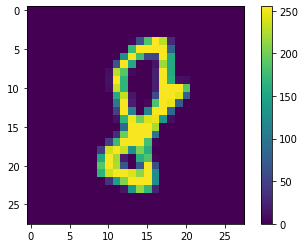

In [10]:
show_img(valid_X.iloc[0, :].values)

### DNN 구축

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.do1 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = x.float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.do1(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### 하이퍼파라미터 설정 및 모델 로드

In [25]:
lr = 0.001
epochs = 25

device = torch.device("cuda")

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

### Train 함수와 Eval 함수 정의

In [26]:
def train(model, train_dl, optimizer):
    
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_dl):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        
def eval(model, test_dl):
    
    model.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_dl):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_dl.dataset)
    test_accuracy = 100. * correct / len(test_dl.dataset)
    
    return test_loss, test_accuracy

### Training

In [27]:
for epoch in range(1, epochs + 1):
    train(model, train_dl, optimizer)
    test_loss, test_accuracy = eval(model, valid_dl)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

[1] Test Loss: 0.2012, Accuracy: 94.46%
[2] Test Loss: 0.1845, Accuracy: 95.07%
[3] Test Loss: 0.1867, Accuracy: 95.47%
[4] Test Loss: 0.1823, Accuracy: 96.00%
[5] Test Loss: 0.2292, Accuracy: 95.13%
[6] Test Loss: 0.1613, Accuracy: 96.58%
[7] Test Loss: 0.1706, Accuracy: 96.21%
[8] Test Loss: 0.1709, Accuracy: 96.67%
[9] Test Loss: 0.1719, Accuracy: 96.42%
[10] Test Loss: 0.1864, Accuracy: 96.44%
[11] Test Loss: 0.1702, Accuracy: 96.80%
[12] Test Loss: 0.2094, Accuracy: 96.48%
[13] Test Loss: 0.2049, Accuracy: 96.72%
[14] Test Loss: 0.2310, Accuracy: 96.56%
[15] Test Loss: 0.2654, Accuracy: 96.27%
[16] Test Loss: 0.2267, Accuracy: 96.97%
[17] Test Loss: 0.2574, Accuracy: 96.66%
[18] Test Loss: 0.2244, Accuracy: 96.89%
[19] Test Loss: 0.2456, Accuracy: 96.77%
[20] Test Loss: 0.2590, Accuracy: 96.82%
[21] Test Loss: 0.2216, Accuracy: 96.87%
[22] Test Loss: 0.2438, Accuracy: 96.47%
[23] Test Loss: 0.2524, Accuracy: 96.74%
[24] Test Loss: 0.2536, Accuracy: 97.08%
[25] Test Loss: 0.2932, A

### Test Dataset 불러오기 및 Inference 작업

In [39]:
test_df = pd.read_csv('test.csv')
submit_df = pd.read_csv('sample_submission.csv')
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
pred_list = []

for index, pixel in enumerate(torch.Tensor(test_df.values).type(torch.float32)):
    pixel = pixel.to(device)
    output = model(pixel)
    _, pred = torch.max(output, 0)
    pred = pred.to("cpu").numpy()
    print(pred)
    pred_list.append(pred)

2
0
9
9
3
7
0
3
0
3
5
7
4
0
4
3
3
1
9
0
9
1
1
5
7
4
2
7
4
7
7
5
4
2
6
2
5
5
1
6
7
7
4
9
8
7
8
2
6
7
6
8
8
3
8
2
1
2
2
0
4
1
7
0
0
0
1
9
0
1
6
5
8
8
2
8
5
9
2
3
5
9
1
0
9
2
4
3
6
7
2
0
6
6
1
4
3
9
7
4
0
9
2
0
7
3
0
5
0
8
0
0
4
7
1
7
1
1
3
3
3
7
2
8
6
3
8
7
8
4
3
5
6
0
0
0
3
1
3
6
8
3
4
5
5
8
7
7
2
8
4
3
5
6
5
3
7
5
7
8
3
0
4
5
1
2
7
6
3
0
2
7
9
6
1
3
7
4
1
2
4
2
5
2
4
9
2
1
6
0
6
1
4
9
6
0
9
7
6
9
1
9
0
9
9
0
8
4
6
2
0
9
3
6
3
2
1
6
3
4
2
3
1
2
2
0
4
6
1
0
0
4
9
1
7
3
2
3
8
6
8
6
2
8
5
5
4
8
3
9
9
7
1
3
8
4
5
1
4
5
6
3
3
5
7
0
6
8
3
1
6
0
6
3
9
8
1
5
8
4
0
9
2
0
5
3
7
8
9
9
5
7
7
9
9
6
3
0
3
3
6
9
8
2
6
2
7
1
4
5
8
5
9
0
0
3
8
4
1
8
4
1
1
9
8
4
5
1
5
3
6
3
1
3
0
9
0
0
6
0
6
3
1
8
6
0
6
5
2
2
6
7
7
2
5
8
3
9
2
7
8
6
3
8
4
2
3
8
1
6
4
8
7
9
7
6
9
5
3
7
6
5
5
9
2
6
2
1
3
7
1
7
9
9
6
1
1
1
7
3
9
7
6
1
1
1
9
3
8
5
5
0
4
1
2
3
1
1
3
5
9
6
6
5
3
1
4
7
4
7
4
8
5
2
8
1
3
9
5
0
8
4
7
4
4
4
1
5
3
9
5
7
6
9
5
9
2
3
5
6
6
7
5
0
5
1
7
4
4
1
1
4
9
5
6
0
1
3
1
0
4
8
1
2
7
9
4
8
3
7
7
4
2
4
6
7
6
3
2
0


3
5
2
8
9
8
2
2
9
7
1
7
7
2
7
3
2
2
8
4
0
2
2
6
1
1
2
2
2
3
0
1
6
3
9
4
3
9
7
9
0
7
3
5
2
3
0
1
9
9
7
9
2
7
4
7
0
6
5
1
9
5
2
7
2
2
5
6
3
5
8
2
3
3
1
4
7
3
8
4
5
7
4
1
9
0
4
8
0
6
5
6
5
2
0
3
3
1
6
1
4
1
1
1
1
3
9
1
0
4
2
9
5
5
9
5
5
2
5
0
8
0
4
2
4
3
8
7
9
4
0
1
4
9
4
4
3
2
0
8
4
1
0
9
3
2
4
6
9
0
6
1
1
7
4
7
8
7
5
7
0
1
8
4
2
5
4
8
9
1
0
2
2
7
8
4
4
7
6
9
4
1
7
8
8
3
4
2
4
1
8
7
8
7
4
9
4
7
3
6
9
1
5
1
0
1
8
1
6
8
3
3
6
5
5
8
1
9
2
3
7
9
9
2
9
8
3
4
5
1
4
9
6
1
3
5
0
9
6
5
3
5
8
5
0
2
6
8
9
9
9
6
6
7
5
8
2
0
9
5
0
1
9
7
2
3
3
0
4
8
3
1
3
9
0
3
8
4
9
4
6
8
9
6
9
8
8
6
5
0
4
8
6
0
0
9
1
4
2
5
6
3
8
8
8
8
2
4
2
7
6
4
7
8
6
9
8
6
3
5
4
3
9
9
3
0
8
2
9
1
6
9
1
0
1
8
7
6
5
5
4
1
7
3
9
1
1
2
3
9
0
7
2
2
4
1
7
7
7
8
3
5
1
6
2
1
0
8
7
2
5
1
1
8
6
9
6
6
9
8
1
7
4
9
8
6
7
8
0
7
6
1
6
8
1
3
9
0
7
5
3
2
7
0
8
1
4
0
8
7
0
6
5
1
7
0
1
5
6
1
4
8
6
8
9
5
1
0
2
2
0
7
8
3
5
1
8
3
7
6
9
8
4
9
1
0
3
3
5
9
2
7
6
3
3
8
0
0
9
7
5
5
0
3
0
7
2
1
0
7
1
5
7
0
2
5
4
2
6
1
3
1
1
3
6
6
8
4
2
3
0
1
4
4
1
8
8
8
7
6


4
1
9
2
8
4
6
7
8
6
9
8
4
5
1
2
0
2
9
6
1
5
0
9
5
2
7
5
8
1
5
1
1
0
5
4
2
0
0
9
0
2
7
7
5
2
5
4
6
3
9
5
4
0
5
6
3
2
3
1
6
2
4
4
4
0
5
1
8
0
3
4
5
0
2
2
0
1
1
6
1
4
3
1
5
9
9
2
5
0
0
2
4
7
8
2
8
4
4
4
4
8
0
5
8
5
4
7
4
4
9
2
4
8
3
0
9
8
7
6
2
4
2
6
3
2
7
5
1
0
2
9
9
0
4
2
7
0
5
4
4
1
5
2
6
8
1
2
8
3
3
2
9
7
1
4
4
6
9
0
2
4
4
5
7
8
9
4
2
4
1
7
8
2
8
2
1
2
9
7
7
0
1
2
0
9
4
2
1
4
5
0
8
6
1
9
5
1
6
2
1
8
0
5
1
9
9
6
6
5
1
1
7
9
4
2
7
3
4
6
0
6
3
0
6
3
0
1
3
2
6
3
2
0
5
9
1
3
9
0
2
0
5
8
9
6
6
5
2
4
7
2
2
7
9
1
3
9
9
2
6
4
9
7
6
0
0
4
8
4
9
8
3
5
1
7
7
1
4
1
6
3
9
7
6
6
1
9
8
0
0
4
4
8
3
1
7
5
7
3
7
4
1
0
3
2
4
3
2
2
6
0
9
9
2
3
1
8
6
4
2
2
1
7
3
1
9
5
0
6
8
1
7
8
3
7
6
7
7
3
7
2
4
5
7
7
9
0
9
1
8
1
8
4
4
1
9
9
6
1
7
5
3
5
3
7
8
0
0
1
0
3
6
6
1
9
4
0
1
0
2
0
6
7
7
5
3
1
8
9
7
0
4
6
2
5
0
6
5
6
8
3
4
1
8
4
6
8
7
1
8
6
8
1
2
3
3
2
3
3
6
8
2
7
6
8
8
0
9
2
7
7
5
3
1
2
3
1
4
3
6
4
8
3
1
3
6
9
6
7
0
3
9
0
7
7
3
0
0
9
3
5
7
9
8
6
0
7
7
2
8
7
9
1
2
3
6
0
7
8
1
0
3
6
9
9
5
0
5
0
1
1
8
2
5
9
5
4
0
5


2
6
1
4
6
5
1
1
7
3
8
3
8
8
1
9
8
1
6
8
4
2
2
8
3
3
4
5
2
7
0
3
9
5
4
7
4
8
0
2
9
2
1
8
4
8
0
3
7
0
8
5
3
8
0
5
1
3
6
9
6
5
4
7
1
5
6
5
2
1
0
6
2
2
9
9
1
6
3
3
3
7
2
9
8
5
0
1
6
6
0
1
1
8
7
9
4
9
9
0
8
8
6
7
1
4
3
6
8
8
1
1
6
9
8
1
1
1
6
1
6
9
3
3
0
5
7
7
5
7
5
5
6
0
0
1
3
4
8
8
8
7
7
2
8
6
4
7
4
8
0
6
6
9
5
1
0
6
1
6
7
1
3
2
4
0
7
9
3
4
4
3
2
5
0
4
5
5
6
8
5
6
4
4
8
6
0
9
4
1
7
3
1
7
9
9
9
2
8
0
5
1
4
3
2
4
8
1
5
8
1
4
4
1
7
7
5
6
3
2
0
3
9
1
9
4
5
1
3
9
9
4
3
2
8
1
8
6
8
1
7
0
2
0
9
0
5
1
5
0
8
0
9
3
8
1
8
7
1
8
6
6
4
0
8
6
3
7
9
2
2
5
1
4
3
3
6
9
1
0
7
2
5
4
7
5
1
9
9
3
4
3
3
8
8
7
0
8
3
7
2
1
8
6
1
2
7
9
1
0
6
5
0
2
3
9
1
7
0
8
6
7
4
9
5
7
2
9
2
3
8
2
1
7
5
1
4
5
1
8
1
7
4
4
1
3
7
0
5
8
9
2
6
5
1
1
5
1
8
4
2
5
5
8
7
6
9
0
7
9
8
6
0
8
2
4
0
2
6
4
7
2
8
8
3
9
9
1
4
0
2
1
0
0
0
9
2
3
8
3
1
9
3
0
2
8
6
0
8
7
4
5
6
2
8
4
3
0
0
0
7
7
8
4
8
6
4
2
1
2
0
6
7
4
3
5
2
0
0
4
4
9
8
5
1
4
1
2
1
5
4
9
9
5
1
8
1
5
7
4
5
6
7
6
3
8
3
4
2
3
6
3
6
8
3
4
2
4
0
1
9
1
7
7
2
7
2
4
1
0
4
6
2
5
6
0
3
1
4
1


8
7
8
1
3
7
2
2
2
4
2
9
2
9
2
8
2
2
5
9
4
3
7
1
0
4
4
2
9
2
0
0
5
0
1
6
0
2
7
5
0
7
4
9
9
3
6
2
9
1
3
2
3
0
0
6
5
8
7
0
6
2
0
9
9
1
5
3
5
8
9
2
7
1
5
0
1
8
0
6
4
7
7
4
9
3
8
8
9
6
7
0
0
8
3
8
7
7
4
2
1
5
7
1
7
8
2
8
0
8
3
1
0
1
3
5
6
6
6
6
1
0
8
3
7
0
5
9
6
6
2
2
5
6
1
7
5
1
7
8
1
0
4
8
3
0
2
1
8
8
3
5
7
2
8
2
9
0
8
4
5
6
7
3
8
5
2
3
3
8
8
9
4
8
8
3
9
6
1
1
6
6
4
4
5
3
2
4
2
5
9
6
8
8
5
9
5
3
0
9
2
6
3
9
3
9
6
8
9
8
3
7
2
7
7
7
4
9
7
4
6
1
8
7
9
5
8
1
2
9
3
1
8
5
1
4
1
1
8
5
8
2
2
5
2
7
5
3
6
8
8
9
6
6
1
9
9
0
0
2
3
4
7
5
5
6
9
9
2
3
9
7
3
8
6
0
0
0
7
8
6
3
6
6
6
0
7
7
3
8
1
9
6
7
9
4
7
0
1
6
4
2
4
8
5
3
8
5
8
2
8
3
2
4
7
4
2
6
3
7
5
2
0
3
4
5
2
8
7
1
4
8
8
9
1
5
2
6
7
7
4
6
5
4
6
0
0
7
9
5
8
3
6
3
8
8
3
6
1
7
9
9
1
8
8
1
4
1
9
5
9
1
9
8
2
6
4
8
5
1
7
9
8
1
6
8
8
6
1
1
2
1
8
7
0
7
9
4
4
2
6
3
2
9
3
6
5
5
5
7
6
5
0
7
8
3
5
4
3
4
3
7
5
6
2
6
0
2
9
1
1
1
2
2
3
9
8
8
9
8
9
5
5
5
2
0
1
7
4
7
5
3
3
3
5
1
9
5
6
9
6
5
1
4
8
2
8
8
6
6
8
3
3
4
2
2
8
0
1
8
0
7
1
9
3
7
1
0
4
3
6
7
8
3
2
7
7
6
5
4


3
2
7
4
9
1
9
0
4
8
6
3
5
3
7
1
5
7
9
7
0
3
1
7
2
7
0
1
5
2
6
7
5
7
9
6
7
2
8
2
9
6
6
7
9
7
8
2
4
9
5
4
4
9
6
7
1
8
6
0
3
2
7
5
9
5
2
3
5
5
7
9
7
9
2
2
8
5
2
9
5
0
1
1
8
0
8
5
6
3
0
8
4
9
6
4
1
0
9
3
3
4
2
8
1
1
6
5
1
2
7
8
6
2
8
7
8
9
7
7
0
2
3
0
8
9
8
4
4
3
9
7
7
9
3
3
3
3
8
0
6
2
7
7
2
5
2
9
8
0
3
3
4
4
3
2
5
2
0
9
7
2
6
1
0
4
5
3
2
7
4
4
4
6
4
7
9
2
1
8
8
3
5
2
9
1
2
7
1
4
4
6
5
7
2
6
4
9
1
6
9
0
9
8
1
1
0
0
9
6
1
1
4
0
7
3
2
1
0
3
2
3
9
7
4
0
7
5
5
4
1
4
8
7
0
0
3
1
0
6
1
1
7
7
6
8
0
5
5
9
2
2
5
9
8
5
2
9
8
6
7
1
0
7
8
5
1
8
1
3
1
8
2
5
3
4
7
3
4
6
7
0
5
6
8
3
3
4
6
3
1
3
7
1
8
1
1
9
4
1
3
6
1
2
1
5
7
7
2
6
1
8
9
4
4
1
6
6
7
4
0
2
3
3
1
7
6
0
7
8
7
8
2
3
2
6
7
2
9
8
7
6
1
6
0
3
5
4
4
9
4
7
1
5
9
9
2
6
9
1
1
9
9
4
2
8
9
2
7
2
7
8
8
6
3
6
7
6
2
1
9
8
1
2
0
8
5
9
5
9
5
1
5
1
7
3
8
4
8
5
2
9
7
7
3
1
1
8
7
1
0
3
8
4
0
0
7
4
5
3
7
9
2
1
2
2
3
4
4
7
1
7
3
3
7
7
2
9
2
4
2
0
9
6
8
2
1
3
9
5
2
0
2
4
0
9
6
5
9
1
1
8
5
0
4
5
9
5
2
0
8
6
6
9
8
2
9
5
8
0
6
0
9
9
9
7
3
4
7
8
1
4
6
7
7
0
3
1
8
4


0
6
2
8
2
8
4
9
6
3
8
3
9
7
1
3
2
6
2
5
5
2
8
6
8
6
7
0
8
9
4
0
2
1
5
1
6
8
1
0
2
5
2
9
8
5
3
6
8
7
2
1
8
3
8
8
4
8
0
9
5
0
2
6
0
2
6
3
3
6
2
8
1
7
6
8
1
2
8
5
8
0
0
1
8
2
0
7
9
9
2
0
4
7
0
6
0
3
1
8
2
2
6
2
7
6
0
0
5
1
6
3
7
8
1
8
5
2
0
6
4
5
4
3
7
7
1
5
8
1
8
3
3
6
8
5
0
9
8
6
2
5
1
5
0
9
8
0
6
5
8
2
0
0
8
2
2
8
3
1
3
5
8
1
0
6
8
3
1
6
0
0
2
1
8
2
6
9
6
5
7
5
3
7
2
1
9
9
0
0
3
6
2
6
9
2
1
4
3
0
3
1
8
7
8
7
1
3
5
1
1
4
2
3
4
9
2
0
1
5
3
1
9
0
6
0
7
1
7
1
2
7
4
0
9
6
2
6
3
2
6
7
5
1
0
4
3
5
9
1
4
3
1
3
5
5
7
6
9
6
7
5
6
9
8
5
1
3
0
6
7
8
7
6
7
4
7
6
3
7
3
6
1
8
2
7
8
7
9
4
1
8
8
7
3
8
8
5
8
2
7
8
9
9
7
7
2
3
1
4
8
5
9
0
4
6
1
5
3
8
3
0
1
8
1
4
6
8
7
2
8
0
5
3
4
6
3
2
2
4
4
9
1
5
1
0
7
4
4
1
8
4
5
5
9
9
2
2
2
4
4
9
6
2
5
2
2
0
8
7
9
5
0
7
0
8
0
1
7
8
2
9
4
0
8
9
4
9
3
5
0
3
3
8
0
7
0
6
7
2
0
3
6
2
1
8
6
0
1
3
8
0
3
6
3
8
1
1
2
6
8
8
9
4
9
5
7
9
6
6
4
9
0
4
0
1
3
0
0
5
9
7
2
1
6
7
2
2
1
8
8
8
9
6
2
9
9
7
4
0
9
6
8
3
4
9
7
9
5
4
7
0
4
6
4
4
4
9
7
7
7
0
0
5
6
7
2
1
3
9
8
0
1
3
8
4
3
1
2
8


In [44]:
submit_df.iloc[:,1] = pred_list
submit_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [45]:
submit_df.to_csv('submit.csv')